In [30]:
!pip install pmdarima

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima

# Bước 1: Đọc dữ liệu
file_path = '/content/BTC-USD.csv'
data = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Hiển thị thông tin cơ bản
print(data.head())
print(data.info())

# Chọn cột 'Close' để phân tích
data = data['Close']




                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2019-03-01  3853.757080  3907.795410  3851.692383  3859.583740  3859.583740   
2019-03-02  3855.318115  3874.607422  3832.127930  3864.415039  3864.415039   
2019-03-03  3862.266113  3875.483643  3836.905762  3847.175781  3847.175781   
2019-03-04  3845.091553  3867.381836  3733.749756  3761.557129  3761.557129   
2019-03-05  3759.832520  3903.916748  3745.183105  3896.375000  3896.375000   

                 Volume  
Date                     
2019-03-01   7661247975  
2019-03-02   7578786076  
2019-03-03   7253558152  
2019-03-04   9029175788  
2019-03-05  10174126415  
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1920 entries, 2019-03-01 to 2024-06-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1920 non-null   float64
 1   High       1920

In [32]:
# Bước 2: Kiểm tra tính dừng
# Kiểm tra ADF
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

print("\nADF Test for Original Series:")
adf_test(data)








ADF Test for Original Series:
ADF Statistic: -0.972461
p-value: 0.763176



ADF Test after Differencing:
ADF Statistic: -10.847695
p-value: 0.000000


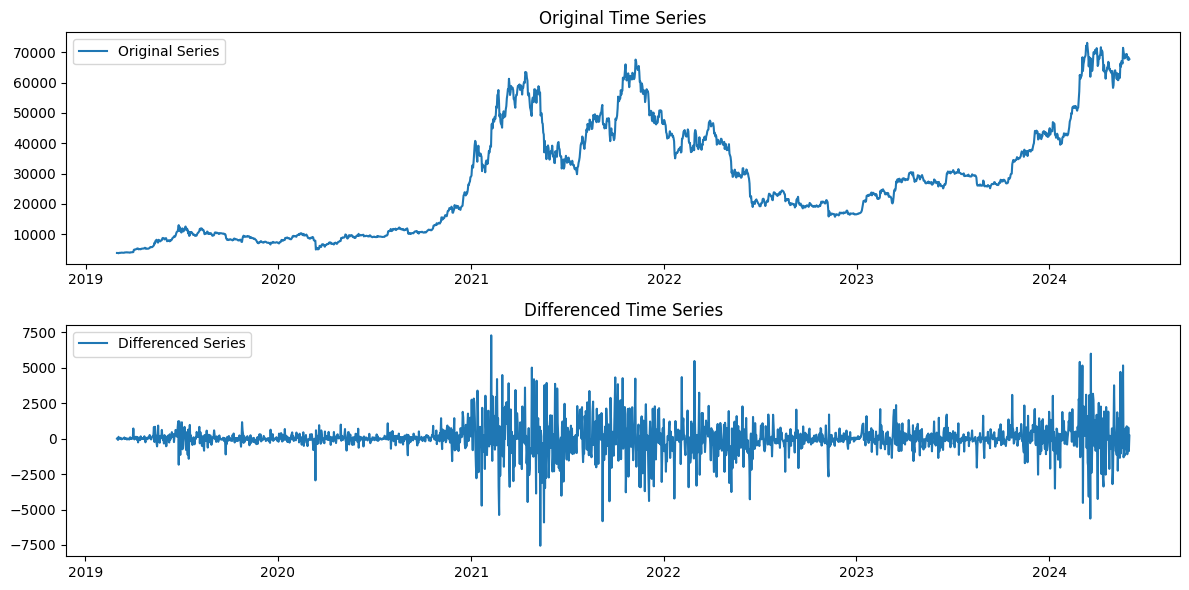

In [33]:
# Bước 3: Làm cho chuỗi có tính dừng (nếu cần)
# Kiểm tra và áp dụng differencing
diff_data = data
if adfuller(data)[1] > 0.05:
    diff_data = data.diff().dropna()
    print("\nADF Test after Differencing:")
    adf_test(diff_data)

# Vẽ biểu đồ chuỗi ban đầu và sau khi differencing
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(data, label='Original Series')
plt.legend(loc='best')
plt.title('Original Time Series')
plt.subplot(212)
if 'diff_data' in locals():
    plt.plot(diff_data, label='Differenced Series')
    plt.legend(loc='best')
    plt.title('Differenced Time Series')
plt.tight_layout()
plt.show()

**Chia tập dữ liệu 7:3**

In [34]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(diff_data) * 0.7)
train, test = diff_data[:train_size], diff_data[train_size:]


In [35]:
# Bước 5: Tìm các thông số ARIMA
# Sử dụng auto_arima để tìm p, d, q tốt nhất
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

# Lấy thông số từ auto_arima
p, d, q = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=22741.046, Time=3.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=22745.624, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=22746.176, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=22746.204, Time=0.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22748.710, Time=0.79 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=22750.112, Time=0.31 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=22752.491, Time=0.65 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=22743.089, Time=5.28 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22748.154, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=22750.109, Time=1.35 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=22750.187, Time=1.39 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=inf, Time=6.34 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=22742.893, Time=6.33 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 26.325 seconds
              

In [36]:
# Bước 6: Huấn luyện mô hình ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
# Bước 7: Dự đoán trên tập kiểm tra
forecast_test = model_fit.forecast(steps=len(test))
test_forecast = pd.Series(forecast_test, index=test.index)

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [39]:
# Bước 8: Đánh giá mô hình
# MSE
mse = mean_squared_error(test, test_forecast)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test, test_forecast)

# MAPE
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 1204271.9017065512
Root Mean Squared Error (RMSE): 1097.3932302080923
Mean Absolute Error (MAE): 661.5788191732458
Mean Absolute Percentage Error (MAPE): 134.36%


In [40]:
# Bước 9: Dự đoán cho 30, 60, và 90 ngày tương lai
future_steps = [30, 60, 90]
future_forecasts = {}
for steps in future_steps:
    future_forecasts[steps] = model_fit.forecast(steps=steps)

# Tạo chỉ số thời gian cho dự đoán tương lai
last_date = diff_data.index[-1]
future_dates = {
    30: pd.date_range(last_date, periods=31)[1:],  # Bỏ ngày đầu tiên vì nó là ngày cuối cùng của dữ liệu
    60: pd.date_range(last_date, periods=61)[1:],
    90: pd.date_range(last_date, periods=91)[1:]
}

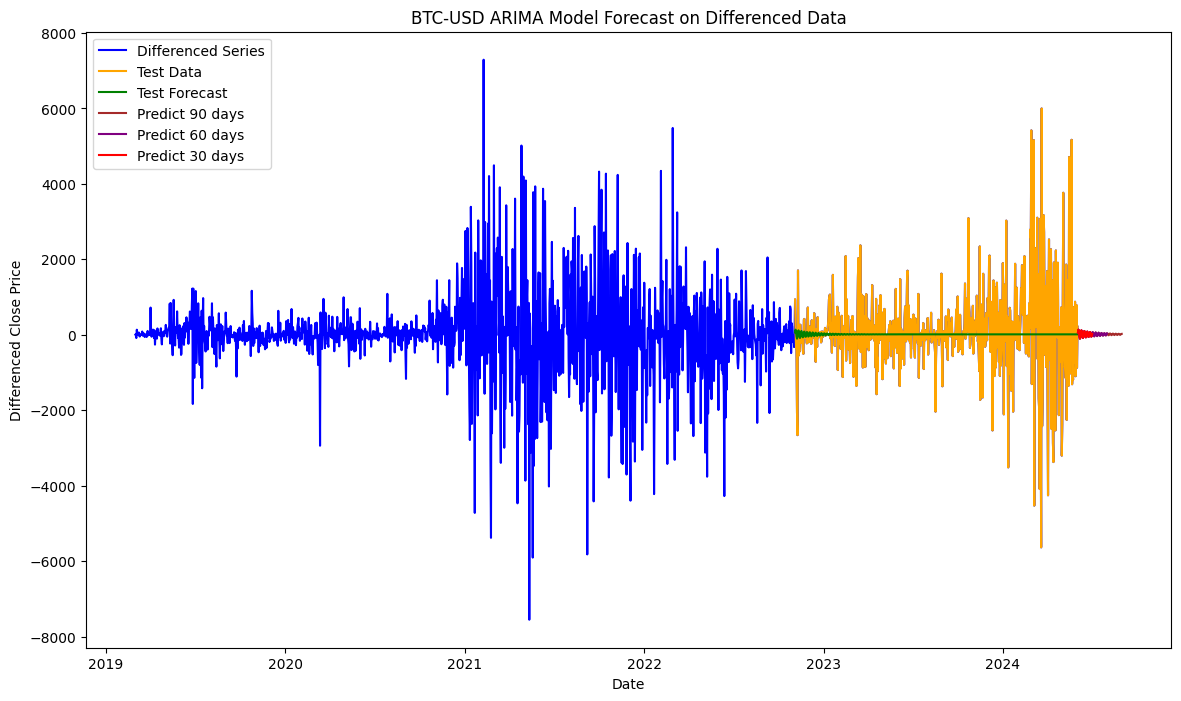

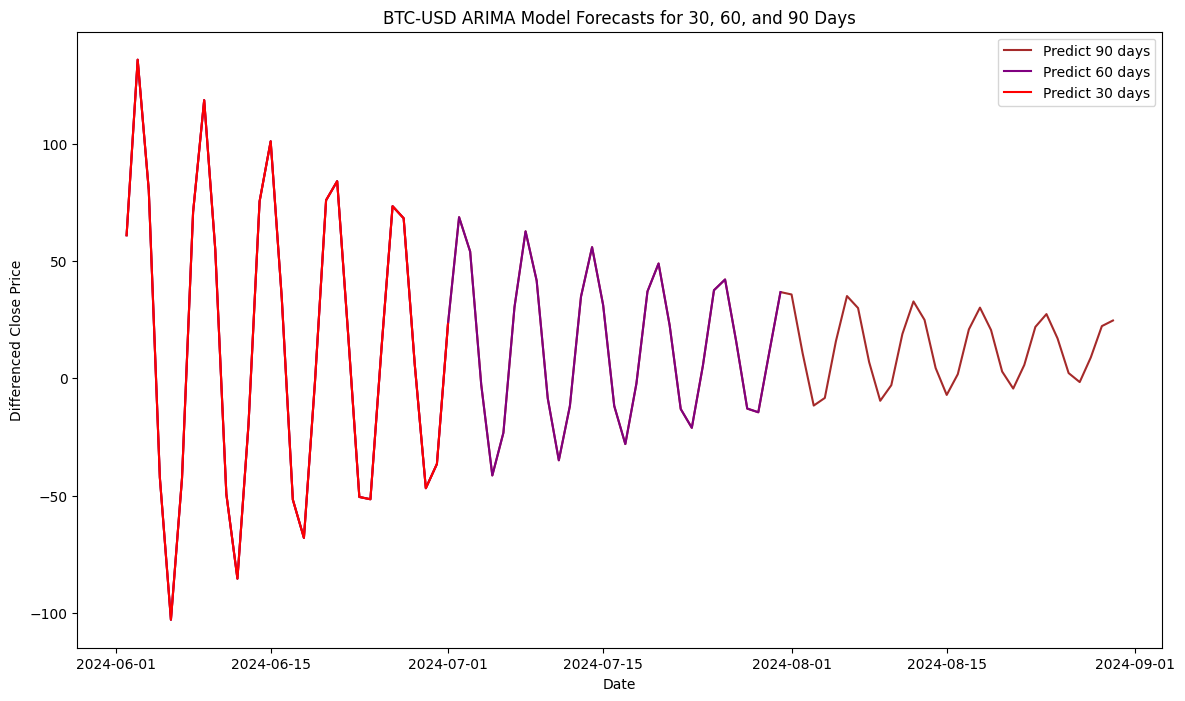

In [41]:

# Bước 10: Vẽ biểu đồ kết hợp

plt.figure(figsize=(14, 8))

# Biểu đồ dữ liệu đã differenced (dữ liệu có tính dừng)
plt.plot(diff_data, label='Differenced Series', color='blue')

# Biểu đồ dữ liệu kiểm tra
plt.plot(test.index, test, label='Test Data', color='orange')

# Biểu đồ dự đoán trên tập kiểm tra
plt.plot(test.index, test_forecast, label='Test Forecast', color='green')

# Dự đoán cho tương lai
# Thứ tự vẽ lần lượt từ 90 ngày, 60 ngày đến 30 ngày để đảm bảo hiển thị rõ ràng
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecast on Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

# Chỉ hiển thị dự đoán cho 30, 60, và 90 ngày
plt.figure(figsize=(14, 8))

# Vẽ từ 90 ngày trước, sau đó là 60 ngày và cuối cùng là 30 ngày
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecasts for 30, 60, and 90 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

Chia dữ liệu 8:2

In [42]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 80:20
train_size = int(len(diff_data) * 0.8)
train, test = diff_data[:train_size], diff_data[train_size:]

In [43]:
# Bước 5: Tìm các thông số ARIMA
# Sử dụng auto_arima để tìm p, d, q tốt nhất
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

# Lấy thông số từ auto_arima
p, d, q = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=6.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25855.500, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=25856.149, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=25856.181, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=25858.108, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25857.213, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 7.233 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1535
Model:                        SARIMAX   Log Likelihood              -12926.750
Date:                Tue, 18 Jun 2024   AIC                          25855.500
Time:                        16:12:13   BIC                          25860.836
Sample:                    03-02-2019   HQIC                         25857.485
          

In [44]:
# Bước 6: Huấn luyện mô hình ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [45]:
# Bước 7: Dự đoán và đánh giá mô hình
# Dự đoán trên tập kiểm tra
forecast = model_fit.forecast(steps=len(test))
test_forecast = pd.Series(forecast, index=test.index)


In [46]:
# Bước 8: Đánh giá mô hình
# MSE
mse = mean_squared_error(test, test_forecast)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test, test_forecast)

# MAPE
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Squared Error (MSE): 1612835.5160798451
Root Mean Squared Error (RMSE): 1269.9746123761076
Mean Absolute Error (MAE): 785.662394378855
Mean Absolute Percentage Error (MAPE): 147.09%


In [47]:
# Bước 9: Dự đoán cho 30, 60, và 90 ngày tương lai
future_steps = [30, 60, 90]
future_forecasts = {}
for steps in future_steps:
    future_forecasts[steps] = model_fit.forecast(steps=steps)

# Tạo chỉ số thời gian cho dự đoán tương lai
last_date = diff_data.index[-1]
future_dates = {
    30: pd.date_range(last_date, periods=31)[1:],  # Bỏ ngày đầu tiên vì nó là ngày cuối cùng của dữ liệu
    60: pd.date_range(last_date, periods=61)[1:],
    90: pd.date_range(last_date, periods=91)[1:]
}

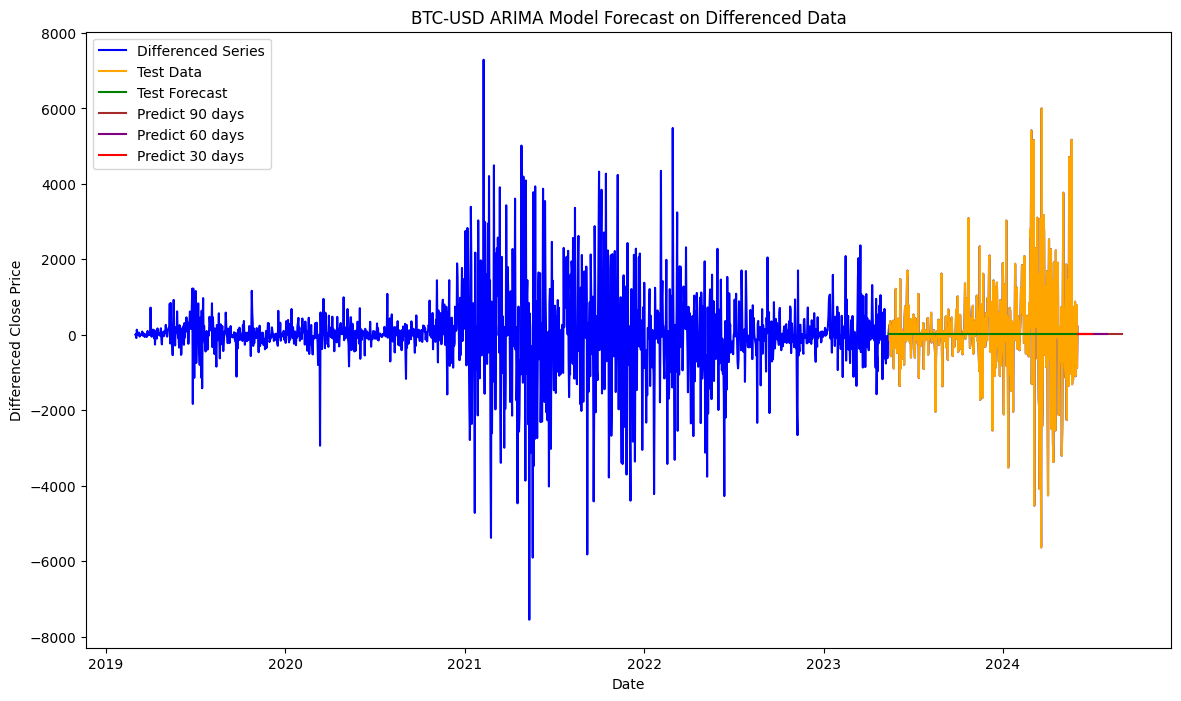

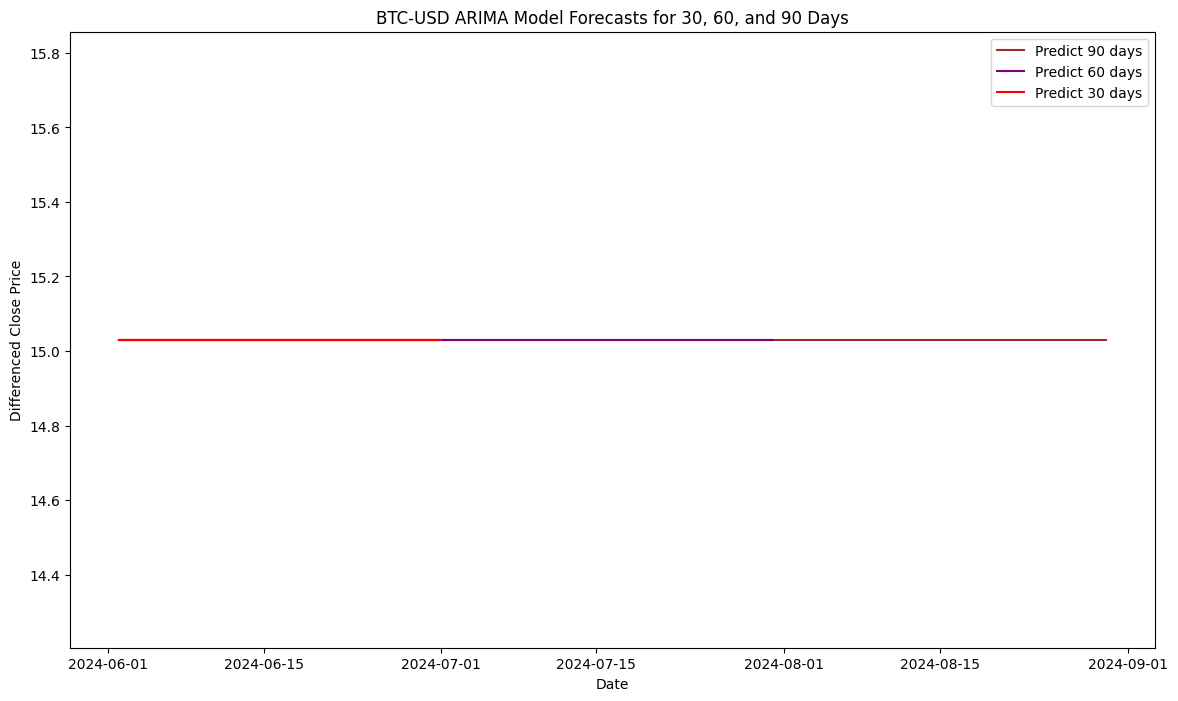

In [48]:

# Bước 10: Vẽ biểu đồ kết hợp

plt.figure(figsize=(14, 8))

# Biểu đồ dữ liệu đã differenced (dữ liệu có tính dừng)
plt.plot(diff_data, label='Differenced Series', color='blue')

# Biểu đồ dữ liệu kiểm tra
plt.plot(test.index, test, label='Test Data', color='orange')

# Biểu đồ dự đoán trên tập kiểm tra
plt.plot(test.index, test_forecast, label='Test Forecast', color='green')

# Dự đoán cho tương lai
# Thứ tự vẽ lần lượt từ 90 ngày, 60 ngày đến 30 ngày để đảm bảo hiển thị rõ ràng
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecast on Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

# Chỉ hiển thị dự đoán cho 30, 60, và 90 ngày
plt.figure(figsize=(14, 8))

# Vẽ từ 90 ngày trước, sau đó là 60 ngày và cuối cùng là 30 ngày
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecasts for 30, 60, and 90 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

**Chia dữ liệu tỷ lệ 6 : 4**

In [49]:
# Bước 4: Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 60:40
train_size = int(len(diff_data) * 0.6)
train, test = diff_data[:train_size], diff_data[train_size:]

In [50]:
# Bước 5: Tìm các thông số ARIMA
# Sử dụng auto_arima để tìm p, d, q tốt nhất
auto_model = auto_arima(train, seasonal=False, trace=True)
print(auto_model.summary())

# Lấy thông số từ auto_arima
p, d, q = auto_model.order

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=19565.042, Time=3.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=19569.744, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=19570.728, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=19570.728, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=19574.035, Time=0.40 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=19574.715, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=19567.110, Time=1.93 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19572.725, Time=0.06 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=19575.289, Time=0.91 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=19575.332, Time=0.65 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=19568.939, Time=3.23 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=19566.197, Time=2.38 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 14.776 seconds
              

In [51]:
# Bước 6: Huấn luyện mô hình ARIMA
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [52]:
# Bước 7: Dự đoán trên tập kiểm tra
forecast_test = model_fit.forecast(steps=len(test))
test_forecast = pd.Series(forecast_test, index=test.index)

In [53]:
# Bước 8: Đánh giá mô hình
# MSE
mse = mean_squared_error(test, test_forecast)

# RMSE
rmse = np.sqrt(mse)

# MAE
mae = mean_absolute_error(test, test_forecast)

# MAPE
mape = np.mean(np.abs((test - test_forecast) / test)) * 100

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 1103916.41397106
Root Mean Squared Error (RMSE): 1050.6742663504517
Mean Absolute Error (MAE): 644.2183123462227
Mean Absolute Percentage Error (MAPE): 164.93%


In [54]:
# Bước 9: Dự đoán cho 30, 60, và 90 ngày tương lai
future_steps = [30, 60, 90]
future_forecasts = {}
for steps in future_steps:
    future_forecasts[steps] = model_fit.forecast(steps=steps)

# Tạo chỉ số thời gian cho dự đoán tương lai
last_date = diff_data.index[-1]
future_dates = {
    30: pd.date_range(last_date, periods=31)[1:],  # Bỏ ngày đầu tiên vì nó là ngày cuối cùng của dữ liệu
    60: pd.date_range(last_date, periods=61)[1:],
    90: pd.date_range(last_date, periods=91)[1:]
}

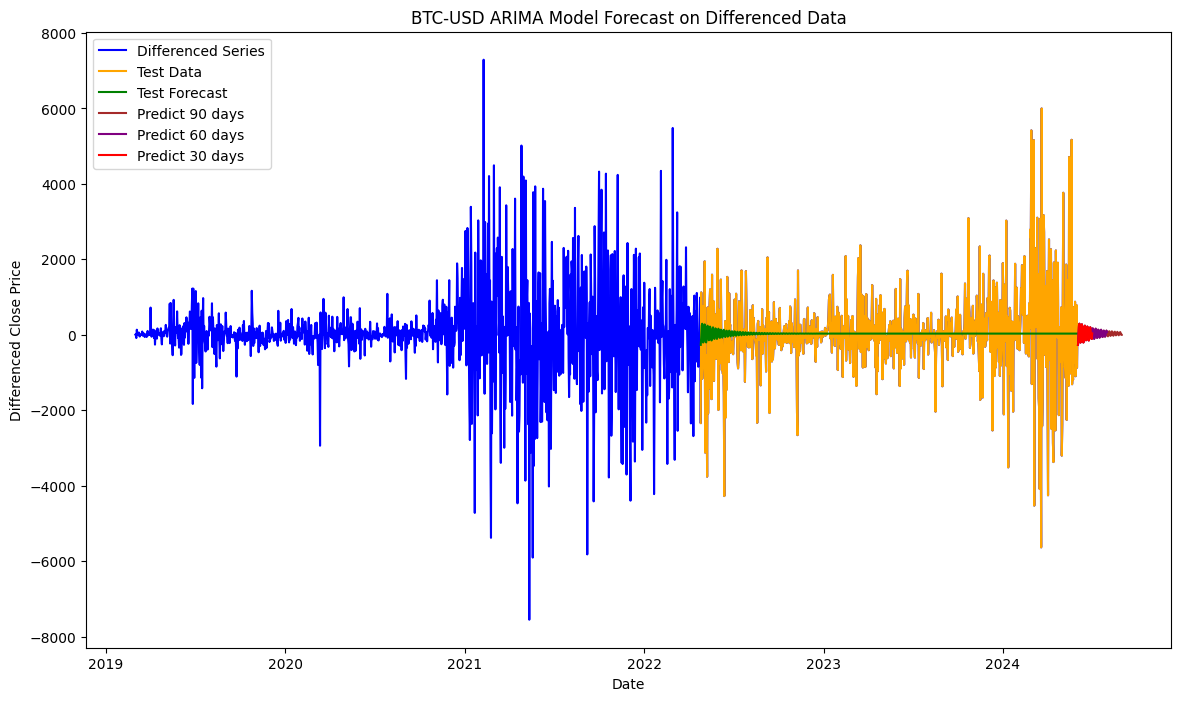

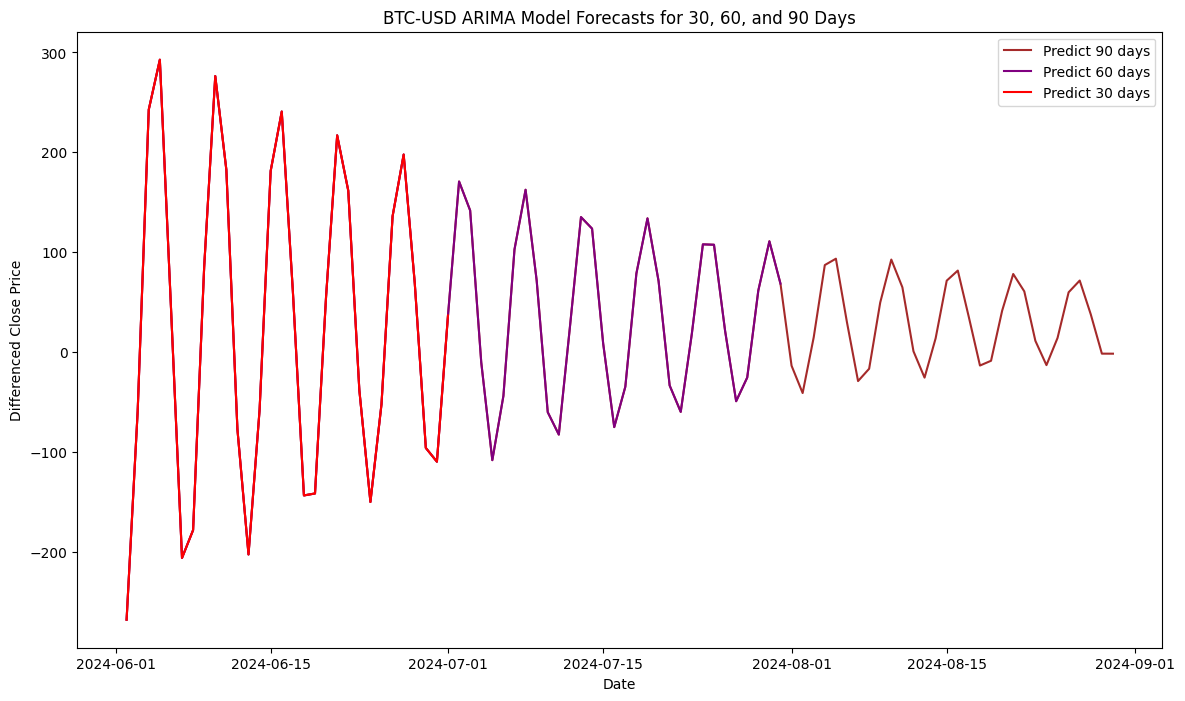

In [55]:

# Bước 10: Vẽ biểu đồ kết hợp

plt.figure(figsize=(14, 8))

# Biểu đồ dữ liệu đã differenced (dữ liệu có tính dừng)
plt.plot(diff_data, label='Differenced Series', color='blue')

# Biểu đồ dữ liệu kiểm tra
plt.plot(test.index, test, label='Test Data', color='orange')

# Biểu đồ dự đoán trên tập kiểm tra
plt.plot(test.index, test_forecast, label='Test Forecast', color='green')

# Dự đoán cho tương lai
# Thứ tự vẽ lần lượt từ 90 ngày, 60 ngày đến 30 ngày để đảm bảo hiển thị rõ ràng
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecast on Differenced Data')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()

# Chỉ hiển thị dự đoán cho 30, 60, và 90 ngày
plt.figure(figsize=(14, 8))

# Vẽ từ 90 ngày trước, sau đó là 60 ngày và cuối cùng là 30 ngày
plt.plot(future_dates[90], future_forecasts[90], label='Predict 90 days', color='brown')
plt.plot(future_dates[60], future_forecasts[60], label='Predict 60 days', color='purple')
plt.plot(future_dates[30], future_forecasts[30], label='Predict 30 days', color='red')

plt.legend(loc='best')
plt.title('BTC-USD ARIMA Model Forecasts for 30, 60, and 90 Days')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.show()